# Tools

In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

# Dataset Preparation

Data split into train/test sets

In [2]:
imgs = os.listdir('dataset/training_set/')
imgs = list(filter(lambda x: x != 'training_set', imgs))
def train_path(p): return f"dataset/training_set/{p}"
imgs = list(map(train_path, imgs))

print("Total training set images:", len(imgs))

Total training set images: 10028


In [3]:
# create train-test split
random.shuffle(imgs)
train, test = imgs[:7000], imgs[7000:]

print("Training set size:", len(train))
print("Testing set size:", len(test))

Training set size: 7000
Testing set size: 3028


Preprocessing

In [4]:
# image normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# image preprocessing
class PreprcessData(Dataset):
    def __init__(self, img_paths, transform):
        super().__init__()
        self.paths = img_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

In [5]:
# create train dataset
train_ds = PreprcessData(train, transform)
train_dl = DataLoader(train_ds, batch_size=64)
print(len(train_ds), len(train_dl))

# create test dataset
test_ds = PreprcessData(test, transform)
test_dl = DataLoader(test_ds, batch_size=64)
print(len(test_ds), len(test_dl))

7000 110
3028 48


# CNN Model Architecture using Pytorch

In [6]:
class ConvNetArch(nn.Module):

    def __init__(self):
        super().__init__()
        # Convolutional layers (3,16,32) for feature extraction
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5, 5), stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5, 5), stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = 1)
        # Fully Conected layers for classification
        self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 500)
        self.fc2 = nn.Linear(in_features = 500, out_features = 50)
        self.fc3 = nn.Linear(in_features = 50, out_features = 2)

    def forward(self, X):
        # ----- Convolutional Layers -----
        # Hidden Layer 1: Conv1 + ReLU + MaxPool
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        # Hidden Layer 2: Conv2 + ReLU + MaxPool
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        # Hidden Layer 3: Conv3 + ReLU + MaxPool
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        # Flatten before the fully connected layers
        X = X.view(X.shape[0], -1)

        # ----- Fully Connected Layers -----
        # Hidden Layer 4: FC1 + ReLU
        X = F.relu(self.fc1(X))
        # Hidden Layer 5: FC2 + ReLU
        X = F.relu(self.fc2(X))
        # Output Layer: FC3 (no activation)
        X = self.fc3(X)
        return X


Initiate the model architecture & Setup

In [7]:
model = ConvNetArch()

losses = []
accuracies = []
epochs = 40
lr = 0.001
start = time.time()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr)

# Model Training Loop

In [9]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# Training
for epoch in range(epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in tqdm(train_dl, desc=f"Training Epoch {epoch+1}/{epochs}"):
        preds = model(X)
        loss = criterion(preds, y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_loss = running_loss / len(train_dl)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_X, test_y in test_dl:
            test_preds = model(test_X)
            loss = criterion(test_preds, test_y)

            test_loss += loss.item()
            _, test_predicted = torch.max(test_preds, 1)
            test_total += test_y.size(0)
            test_correct += (test_predicted == test_y).sum().item()

    test_loss /= len(test_dl)
    test_accuracy = 100. * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{epochs}], "
          f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Training Epoch 1/40: 100%|██████████| 110/110 [00:28<00:00,  3.85it/s]


Epoch [1/40], Training Loss: 0.6740, Training Accuracy: 57.19%, Test Loss: 0.6649, Test Accuracy: 58.36%


Training Epoch 2/40: 100%|██████████| 110/110 [00:26<00:00,  4.10it/s]


Epoch [2/40], Training Loss: 0.6170, Training Accuracy: 65.77%, Test Loss: 0.6182, Test Accuracy: 63.51%


Training Epoch 3/40: 100%|██████████| 110/110 [00:27<00:00,  4.05it/s]


Epoch [3/40], Training Loss: 0.5442, Training Accuracy: 72.03%, Test Loss: 0.5516, Test Accuracy: 72.99%


Training Epoch 4/40: 100%|██████████| 110/110 [01:24<00:00,  1.30it/s]


Epoch [4/40], Training Loss: 0.4847, Training Accuracy: 76.26%, Test Loss: 0.5154, Test Accuracy: 75.26%


Training Epoch 5/40: 100%|██████████| 110/110 [01:13<00:00,  1.49it/s]


Epoch [5/40], Training Loss: 0.4436, Training Accuracy: 79.19%, Test Loss: 0.5159, Test Accuracy: 75.20%


Training Epoch 6/40: 100%|██████████| 110/110 [00:54<00:00,  2.02it/s]


Epoch [6/40], Training Loss: 0.4057, Training Accuracy: 81.63%, Test Loss: 0.4989, Test Accuracy: 76.52%


Training Epoch 7/40: 100%|██████████| 110/110 [00:55<00:00,  1.97it/s]


Epoch [7/40], Training Loss: 0.3538, Training Accuracy: 84.39%, Test Loss: 0.5210, Test Accuracy: 76.02%


Training Epoch 8/40: 100%|██████████| 110/110 [01:00<00:00,  1.81it/s]


Epoch [8/40], Training Loss: 0.3069, Training Accuracy: 86.67%, Test Loss: 0.6018, Test Accuracy: 75.83%


Training Epoch 9/40: 100%|██████████| 110/110 [01:30<00:00,  1.21it/s]


Epoch [9/40], Training Loss: 0.2647, Training Accuracy: 88.89%, Test Loss: 0.6605, Test Accuracy: 73.68%


Training Epoch 10/40: 100%|██████████| 110/110 [01:29<00:00,  1.23it/s]


Epoch [10/40], Training Loss: 0.2494, Training Accuracy: 89.49%, Test Loss: 0.7461, Test Accuracy: 74.41%


Training Epoch 11/40: 100%|██████████| 110/110 [01:23<00:00,  1.32it/s]


Epoch [11/40], Training Loss: 0.2121, Training Accuracy: 91.10%, Test Loss: 0.8491, Test Accuracy: 73.68%


Training Epoch 12/40: 100%|██████████| 110/110 [01:09<00:00,  1.58it/s]


Epoch [12/40], Training Loss: 0.1855, Training Accuracy: 92.46%, Test Loss: 0.9209, Test Accuracy: 75.23%


Training Epoch 13/40: 100%|██████████| 110/110 [01:20<00:00,  1.36it/s]


Epoch [13/40], Training Loss: 0.1028, Training Accuracy: 96.19%, Test Loss: 0.9569, Test Accuracy: 75.36%


Training Epoch 14/40: 100%|██████████| 110/110 [01:20<00:00,  1.37it/s]


Epoch [14/40], Training Loss: 0.0660, Training Accuracy: 97.60%, Test Loss: 1.1919, Test Accuracy: 74.64%


Training Epoch 15/40: 100%|██████████| 110/110 [01:24<00:00,  1.30it/s]


Epoch [15/40], Training Loss: 0.0662, Training Accuracy: 97.54%, Test Loss: 1.2392, Test Accuracy: 75.76%


Training Epoch 16/40: 100%|██████████| 110/110 [01:22<00:00,  1.34it/s]


Epoch [16/40], Training Loss: 0.0713, Training Accuracy: 97.30%, Test Loss: 1.1308, Test Accuracy: 74.64%


Training Epoch 17/40: 100%|██████████| 110/110 [01:24<00:00,  1.30it/s]


Epoch [17/40], Training Loss: 0.0726, Training Accuracy: 97.36%, Test Loss: 1.1533, Test Accuracy: 74.50%


Training Epoch 18/40: 100%|██████████| 110/110 [01:22<00:00,  1.33it/s]


Epoch [18/40], Training Loss: 0.0530, Training Accuracy: 98.16%, Test Loss: 1.3564, Test Accuracy: 75.66%


Training Epoch 19/40: 100%|██████████| 110/110 [00:30<00:00,  3.62it/s]


Epoch [19/40], Training Loss: 0.0433, Training Accuracy: 98.57%, Test Loss: 1.5047, Test Accuracy: 76.39%


Training Epoch 20/40: 100%|██████████| 110/110 [00:27<00:00,  4.01it/s]


Epoch [20/40], Training Loss: 0.0317, Training Accuracy: 98.73%, Test Loss: 1.5111, Test Accuracy: 75.73%


Training Epoch 21/40: 100%|██████████| 110/110 [00:27<00:00,  3.99it/s]


Epoch [21/40], Training Loss: 0.0410, Training Accuracy: 98.66%, Test Loss: 1.5068, Test Accuracy: 76.42%


Training Epoch 22/40: 100%|██████████| 110/110 [00:27<00:00,  4.01it/s]


Epoch [22/40], Training Loss: 0.0411, Training Accuracy: 98.53%, Test Loss: 1.2414, Test Accuracy: 76.06%


Training Epoch 23/40: 100%|██████████| 110/110 [00:27<00:00,  4.00it/s]


Epoch [23/40], Training Loss: 0.0509, Training Accuracy: 98.40%, Test Loss: 1.1060, Test Accuracy: 75.40%


Training Epoch 24/40: 100%|██████████| 110/110 [00:27<00:00,  3.99it/s]


Epoch [24/40], Training Loss: 0.0228, Training Accuracy: 99.29%, Test Loss: 1.5247, Test Accuracy: 75.99%


Training Epoch 25/40: 100%|██████████| 110/110 [00:27<00:00,  4.03it/s]


Epoch [25/40], Training Loss: 0.0138, Training Accuracy: 99.61%, Test Loss: 1.6154, Test Accuracy: 76.52%


Training Epoch 26/40: 100%|██████████| 110/110 [00:27<00:00,  4.02it/s]


Epoch [26/40], Training Loss: 0.0064, Training Accuracy: 99.79%, Test Loss: 1.8864, Test Accuracy: 76.29%


Training Epoch 27/40: 100%|██████████| 110/110 [00:27<00:00,  4.02it/s]


Epoch [27/40], Training Loss: 0.0109, Training Accuracy: 99.67%, Test Loss: 1.7660, Test Accuracy: 76.35%


Training Epoch 28/40: 100%|██████████| 110/110 [00:27<00:00,  3.98it/s]


Epoch [28/40], Training Loss: 0.0147, Training Accuracy: 99.44%, Test Loss: 1.8140, Test Accuracy: 75.07%


Training Epoch 29/40: 100%|██████████| 110/110 [00:27<00:00,  4.03it/s]


Epoch [29/40], Training Loss: 0.0211, Training Accuracy: 99.40%, Test Loss: 1.8052, Test Accuracy: 74.90%


Training Epoch 30/40: 100%|██████████| 110/110 [00:27<00:00,  3.98it/s]


Epoch [30/40], Training Loss: 0.0195, Training Accuracy: 99.24%, Test Loss: 1.7031, Test Accuracy: 75.07%


Training Epoch 31/40: 100%|██████████| 110/110 [00:27<00:00,  4.01it/s]


Epoch [31/40], Training Loss: 0.0254, Training Accuracy: 99.31%, Test Loss: 1.6737, Test Accuracy: 75.76%


Training Epoch 32/40: 100%|██████████| 110/110 [00:27<00:00,  4.02it/s]


Epoch [32/40], Training Loss: 0.0131, Training Accuracy: 99.61%, Test Loss: 1.7094, Test Accuracy: 75.50%


Training Epoch 33/40: 100%|██████████| 110/110 [00:27<00:00,  4.01it/s]


Epoch [33/40], Training Loss: 0.0140, Training Accuracy: 99.60%, Test Loss: 1.9120, Test Accuracy: 75.99%


Training Epoch 34/40: 100%|██████████| 110/110 [00:27<00:00,  3.95it/s]


Epoch [34/40], Training Loss: 0.0072, Training Accuracy: 99.73%, Test Loss: 2.0206, Test Accuracy: 75.96%


Training Epoch 35/40: 100%|██████████| 110/110 [00:27<00:00,  4.01it/s]


Epoch [35/40], Training Loss: 0.0131, Training Accuracy: 99.56%, Test Loss: 1.7945, Test Accuracy: 74.80%


Training Epoch 36/40: 100%|██████████| 110/110 [00:27<00:00,  4.01it/s]


Epoch [36/40], Training Loss: 0.0144, Training Accuracy: 99.51%, Test Loss: 1.9412, Test Accuracy: 76.62%


Training Epoch 37/40: 100%|██████████| 110/110 [00:27<00:00,  4.00it/s]


Epoch [37/40], Training Loss: 0.0095, Training Accuracy: 99.69%, Test Loss: 1.9507, Test Accuracy: 75.13%


Training Epoch 38/40: 100%|██████████| 110/110 [00:27<00:00,  4.04it/s]


Epoch [38/40], Training Loss: 0.0089, Training Accuracy: 99.69%, Test Loss: 1.9964, Test Accuracy: 74.77%


Training Epoch 39/40: 100%|██████████| 110/110 [00:27<00:00,  3.97it/s]


Epoch [39/40], Training Loss: 0.0120, Training Accuracy: 99.63%, Test Loss: 1.9286, Test Accuracy: 74.54%


Training Epoch 40/40: 100%|██████████| 110/110 [00:27<00:00,  3.95it/s]


Epoch [40/40], Training Loss: 0.0255, Training Accuracy: 99.24%, Test Loss: 1.5241, Test Accuracy: 74.87%


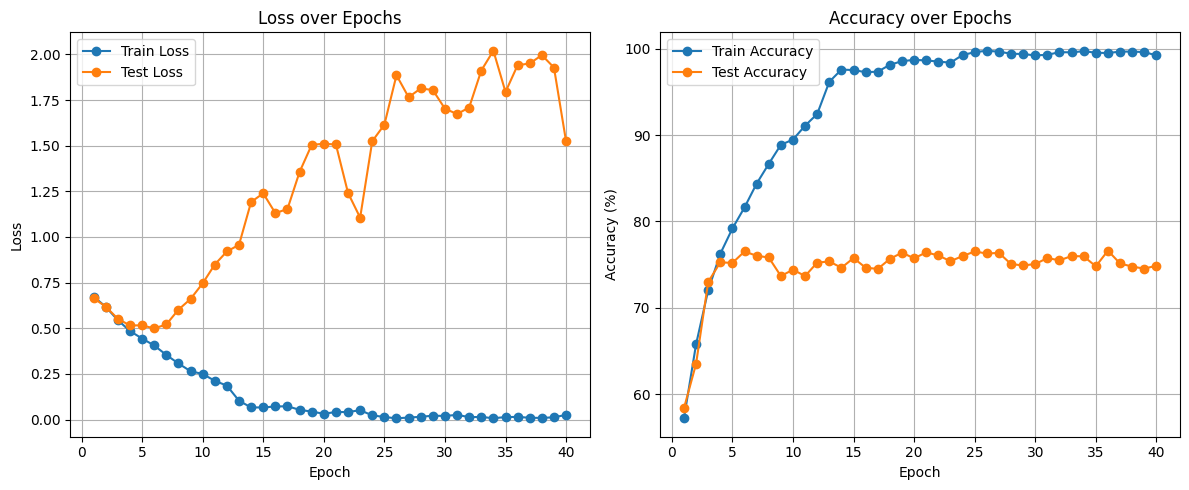

In [11]:
# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing the model

Preparation of test set

In [ ]:
test_files = os.listdir('dataset/test_set/')
test_files = list(filter(lambda x: x != 'test_set', test_files))
def test_path(p): 
    return f"dataset/test_set/{p}"
test_files = list(map(test_path, test_files))

class TestData(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = os.path.basename(path)
        return (image, fileid)

test_ds = TestData(test_files, transform)
test_dl = DataLoader(test_ds, batch_size=8)
len(test_ds), len(test_dl)


(50, 7)

Model Evaluation by making predictions

In [ ]:
dog_probs = []
cat_probs = []

# Use the model is in eval mode
model.eval()  

with torch.no_grad():
    for X, fileids in test_dl:
        preds = model(X)  # Raw logits
        probs = F.softmax(preds, dim=1)  # Convert logits to probabilities

        # Class 0 = cat & Class 1 = dog
        cat_list = probs[:, 0].tolist()
        dog_list = probs[:, 1].tolist()

        # Save (filename, probability) for each class
        dog_probs += list(zip(fileids, dog_list))
        cat_probs += list(zip(fileids, cat_list))

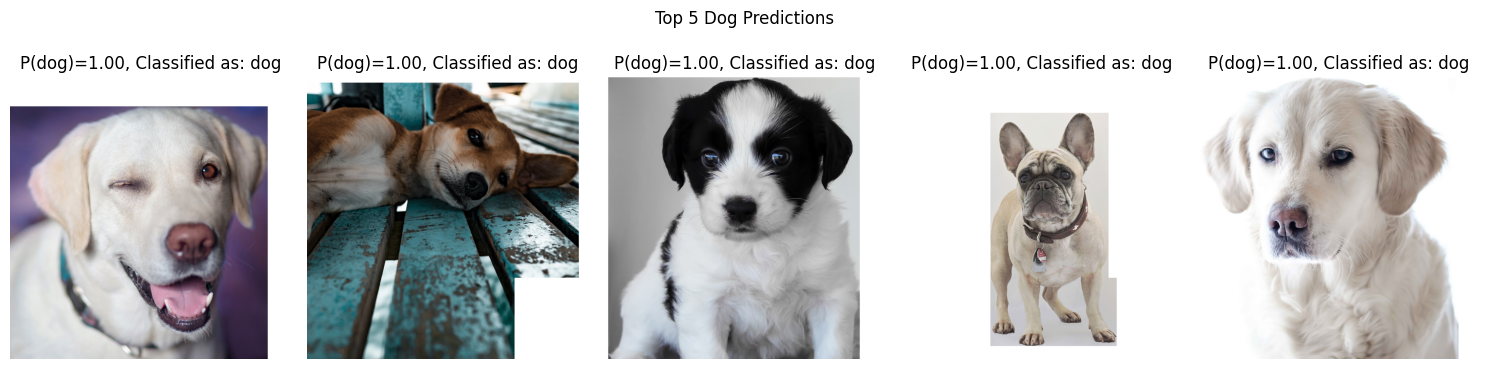

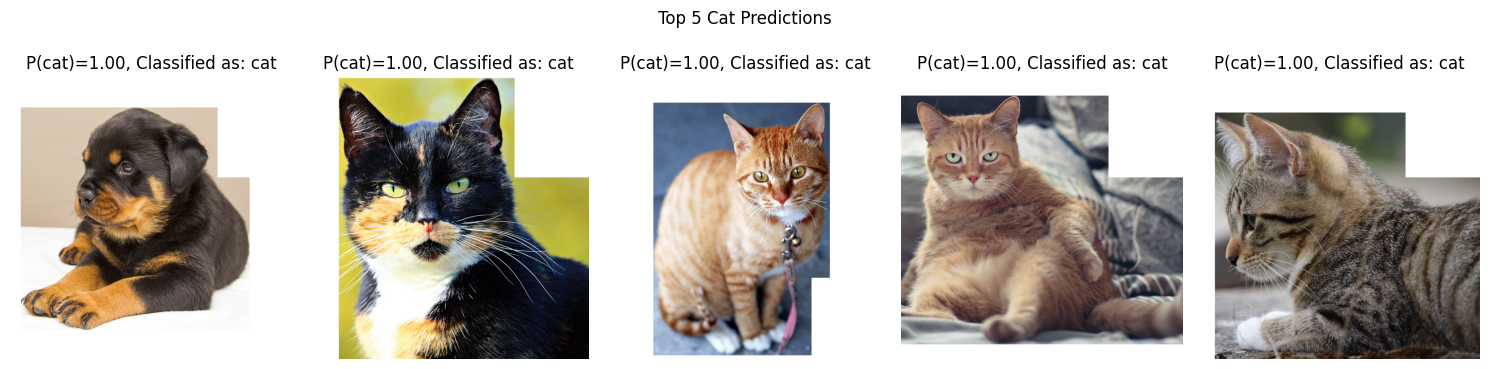

In [ ]:
def predict_imgs(title, top_items, label_type):
    plt.figure(figsize=(15, 4))
    for i, (fileid, prob) in enumerate(top_items):
        img_path = os.path.join("dataset/test_set", fileid)
        image = Image.open(img_path).convert('RGB')

        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        predicted_label = label_type if prob > 0.5 else ("cat" if label_type == "dog" else "dog")
        plt.title(f"P({label_type})={prob:.2f}, Classified as: {predicted_label}")
        plt.axis('off')
    plt.suptitle(f"Top 5 {label_type.capitalize()} Predictions")
    plt.tight_layout()
    plt.show()

top_dogs = sorted(dog_probs, key=lambda x: x[1], reverse=True)[:5]
top_cats = sorted(cat_probs, key=lambda x: x[1], reverse=True)[:5]
predict_imgs("Dog", top_dogs, "dog")
predict_imgs("Cat", top_cats, "cat")
